In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')

#style + file paths
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except OSError:
    try:
        plt.style.use('seaborn-whitegrid')
    except OSError:
        pass
plt.rcParams.update({
    'figure.figsize': (15, 6),
    'figure.dpi': 120,
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 12,
})

RCP_PATH   = 'rcp_trump_approval.csv'
JAN1_PATH  = 'kalshi-price-history-kxaprpotuseoy-26jan01-minute.csv'
JAN9_PATH  = 'kalshi-price-history-kxaprpotus-26jan09-minute.csv'
JAN30_PATH = 'kalshi-price-history-kxaprpotus-26jan30-minute.csv'

MARKETS = {
    'JAN1':  {'path': JAN1_PATH,  'target_date': '2026-01-01',
               'label': 'Jan 1 Market'},
    'JAN9':  {'path': JAN9_PATH,  'target_date': '2026-01-09',
               'label': 'Jan 9 Market'},
    'JAN30': {'path': JAN30_PATH, 'target_date': '2026-01-30',
               'label': 'Jan 30 Market'},
}

print('Configuration loaded.  Markets:', list(MARKETS.keys()))

Configuration loaded.  Markets: ['JAN1', 'JAN9', 'JAN30']


In [2]:
#load data
rcp = pd.read_csv(RCP_PATH)
rcp['date'] = pd.to_datetime(rcp['date'])
rcp['approve']    = rcp['approve'].str.rstrip('%').astype(float)
rcp['disapprove'] = rcp['disapprove'].str.rstrip('%').astype(float)
rcp = rcp.sort_values('date').reset_index(drop=True)

print('RCP Trump Approval Data')
print(f'  Rows          : {len(rcp)}')
print(f'  Date range    : {rcp["date"].min().date()}  to  {rcp["date"].max().date()}')
print(f'  Approval range: {rcp["approve"].min():.1f}%  to  {rcp["approve"].max():.1f}%')
rcp.tail(10)

RCP Trump Approval Data
  Rows          : 376
  Date range    : 2025-01-27  to  2026-02-06
  Approval range: 42.2%  to  50.5%


,date,approve,disapprove
366,2026-01-28,42.8,54.9
367,2026-01-29,42.6,55.0
368,2026-01-30,42.6,55.1
369,2026-01-31,42.4,54.8
370,2026-02-01,42.6,54.6
371,2026-02-02,42.6,54.6
372,2026-02-03,42.9,54.2
373,2026-02-04,42.6,54.6
374,2026-02-05,42.4,54.8
375,2026-02-06,42.3,54.9


In [3]:
#load Klashi data
def load_kalshi(path):
    df = pd.read_csv(path)
    df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True).dt.tz_localize(None)
    bucket_cols = [c for c in df.columns if c != 'timestamp']
    for c in bucket_cols:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    return df, bucket_cols

for key, cfg in MARKETS.items():
    df, bcols = load_kalshi(cfg['path'])
    cfg['raw_df']      = df
    cfg['bucket_cols'] = bcols
    n_miss  = df[bcols].isnull().sum().sum()
    n_total = df[bcols].size
    print(f'\n {key} ({cfg["label"]})')
    print(f'  Rows    : {len(df):,}   Buckets: {len(bcols)}')
    print(f'  Span    : {df["timestamp"].min()}  to  {df["timestamp"].max()}')
    print(f'  Missing : {n_miss:,} / {n_total:,}  ({100*n_miss/n_total:.1f}%)')
    print(f'  Buckets : {bcols}')


 JAN1 (Jan 1 Market)
  Rows    : 5,466   Buckets: 12
  Span    : 2025-09-18 05:09:00  to  2026-01-01 16:00:00
  Missing : 283 / 65,592  (0.4%)
  Buckets : ['39.9 or below', '40.0 to 40.9', '41.0 to 41.9', '42.0 to 42.9', '43.0 to 43.9', '44.0 to 44.9', '45.0 to 45.9', '46.0 to 46.9', '47.0 to 47.9', '48.0 to 48.9', '49.0 to 50.0', '50.1 or above']

 JAN9 (Jan 9 Market)
  Rows    : 2,524   Buckets: 8
  Span    : 2026-01-02 19:42:00  to  2026-01-09 16:00:00
  Missing : 58 / 20,192  (0.3%)
  Buckets : ['41.9 or below', '42.0 to 42.3', '42.4 to 42.7', '42.8 to 43.1', '43.2 to 43.5', '43.6 to 43.9', '44.0 to 44.3', '44.4 or above']

 JAN30 (Jan 30 Market)
  Rows    : 726   Buckets: 8
  Span    : 2026-01-24 05:04:00  to  2026-01-30 16:00:00
  Missing : 43 / 5,808  (0.7%)
  Buckets : ['41.9 or below', '42.0 to 42.2', '42.3 to 42.5', '42.6 to 42.8', '42.9 to 43.1', '43.2 to 43.4', '43.5 to 43.7', '43.8 or above']


In [4]:
#parse bucket bounds & midpoints
def parse_buckets(bucket_cols):
    '''Return dict  bucket_name: {lower, upper, midpoint, edge}.'''
    info = {}
    interior_widths = []
    for b in bucket_cols:
        s = b.strip()
        if ' to ' in s:
            parts = s.split(' to ')
            lo, hi = float(parts[0]), float(parts[1])
            info[b] = {'lower': lo, 'upper': hi, 'edge': None}
            interior_widths.append(hi - lo)
        elif 'or below' in s:
            hi = float(s.split(' or')[0].strip())
            info[b] = {'upper': hi, 'edge': 'below'}
        elif 'or above' in s:
            lo = float(s.split(' or')[0].strip())
            info[b] = {'lower': lo, 'edge': 'above'}
    w = np.mean(interior_widths) if interior_widths else 1.0
    for d in info.values():
        if d['edge'] == 'below':
            d['lower'] = d['upper'] - w
        elif d['edge'] == 'above':
            d['upper'] = d['lower'] + w
        d['midpoint'] = (d['lower'] + d['upper']) / 2
    return info

#normalise raw prices for probability distributions
def process_market(df, bucket_cols, bucket_info):
    midpoints = np.array([bucket_info[b]['midpoint'] for b in bucket_cols])
    prices    = df[bucket_cols].fillna(0).copy()
    row_sums  = prices.sum(axis=1)
    probs     = prices.div(row_sums.replace(0, np.nan), axis=0).fillna(0)

    implied   = probs.values @ midpoints
    mode_idx  = probs.values.argmax(axis=1)

    out = df[['timestamp']].copy()
    for i, b in enumerate(bucket_cols):
        out[f'prob_{b}'] = probs.iloc[:, i].values
    out['raw_price_sum']    = row_sums.values
    out['implied_approval'] = implied
    out['mode_bucket']      = [bucket_cols[j] for j in mode_idx]
    out['mode_midpoint']    = midpoints[mode_idx]
    return out, midpoints

#run on every market
for key, cfg in MARKETS.items():
    cfg["bucket_info"] = parse_buckets(cfg["bucket_cols"])
    cfg["processed"], cfg["midpoints"] = process_market(
        cfg["raw_df"], cfg["bucket_cols"], cfg["bucket_info"]
    )
    print(f"{key}: parsed {len(cfg['bucket_cols'])} buckets, processed {len(cfg['processed'])} rows")

JAN1: parsed 12 buckets, processed 5466 rows
JAN9: parsed 8 buckets, processed 2524 rows
JAN30: parsed 8 buckets, processed 726 rows


In [5]:
# match each market to the realized RCP outcome
def find_realized_bucket(outcome, bucket_cols, bucket_info):
    '''Return the bucket name that contains *outcome*.'''
    for b in bucket_cols:
        bi = bucket_info[b]
        if bi['edge'] == 'below' and outcome <= bi['upper']:
            return b
        if bi['edge'] == 'above' and outcome >= bi['lower']:
            return b
        if bi['edge'] is None and bi['lower'] <= outcome <= bi['upper']:
            return b
    return None

for key, cfg in MARKETS.items():
    target = pd.Timestamp(cfg['target_date'])
    cands  = rcp[rcp['date'] <= target].sort_values('date')
    row = cands.iloc[-1]
    cfg['outcome']            = row['approve']
    cfg['outcome_date']       = row['date']
    cfg['realized_bucket']    = find_realized_bucket(
        row['approve'], cfg['bucket_cols'], cfg['bucket_info'])
    cfg['realized_bucket_idx'] = (
        cfg['bucket_cols'].index(cfg['realized_bucket'])
        if cfg['realized_bucket'] else None)

    print(f'\n{key}  ({cfg["label"]})')
    print(f'  Target date      : {target.date()}')
    print(f'  RCP date used    : {row["date"].date()}')
    print(f'  Realized approval: {row["approve"]:.1f}%')
    print(f'  Realized bucket  : {cfg["realized_bucket"]}')


JAN1  (Jan 1 Market)
  Target date      : 2026-01-01
  RCP date used    : 2026-01-01
  Realized approval: 43.4%
  Realized bucket  : 43.0 to 43.9

JAN9  (Jan 9 Market)
  Target date      : 2026-01-09
  RCP date used    : 2026-01-09
  Realized approval: 44.1%
  Realized bucket  : 44.0 to 44.3

JAN30  (Jan 30 Market)
  Target date      : 2026-01-30
  RCP date used    : 2026-01-30
  Realized approval: 42.6%
  Realized bucket  : 42.6 to 42.8


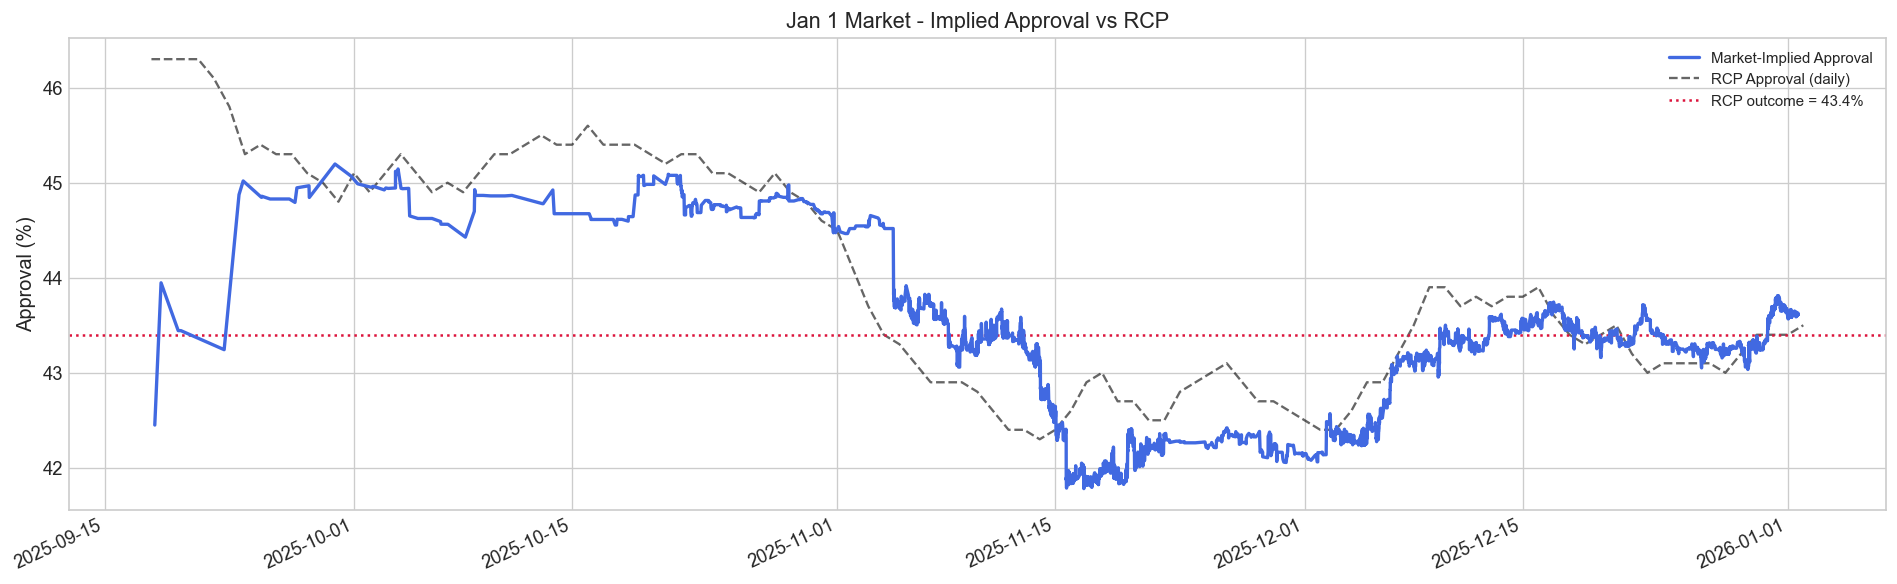

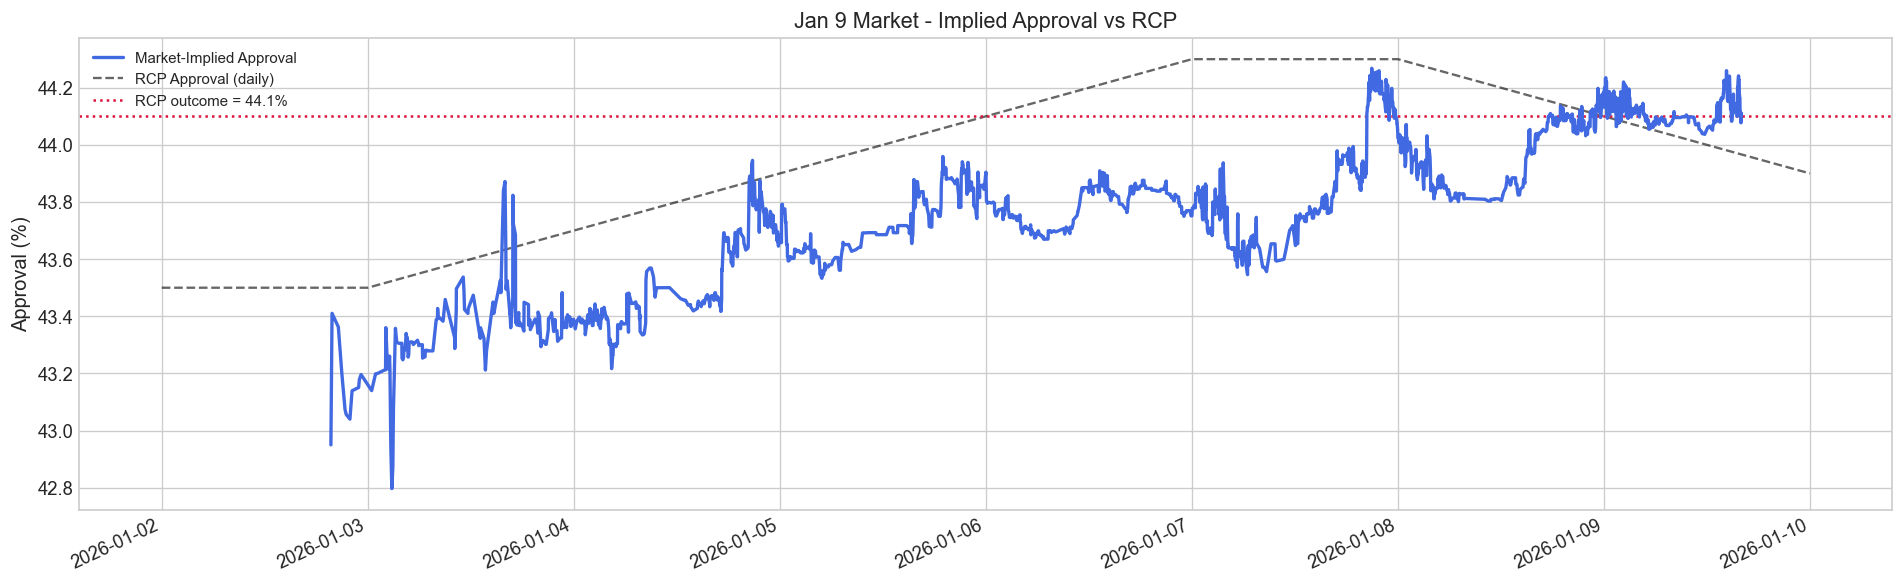

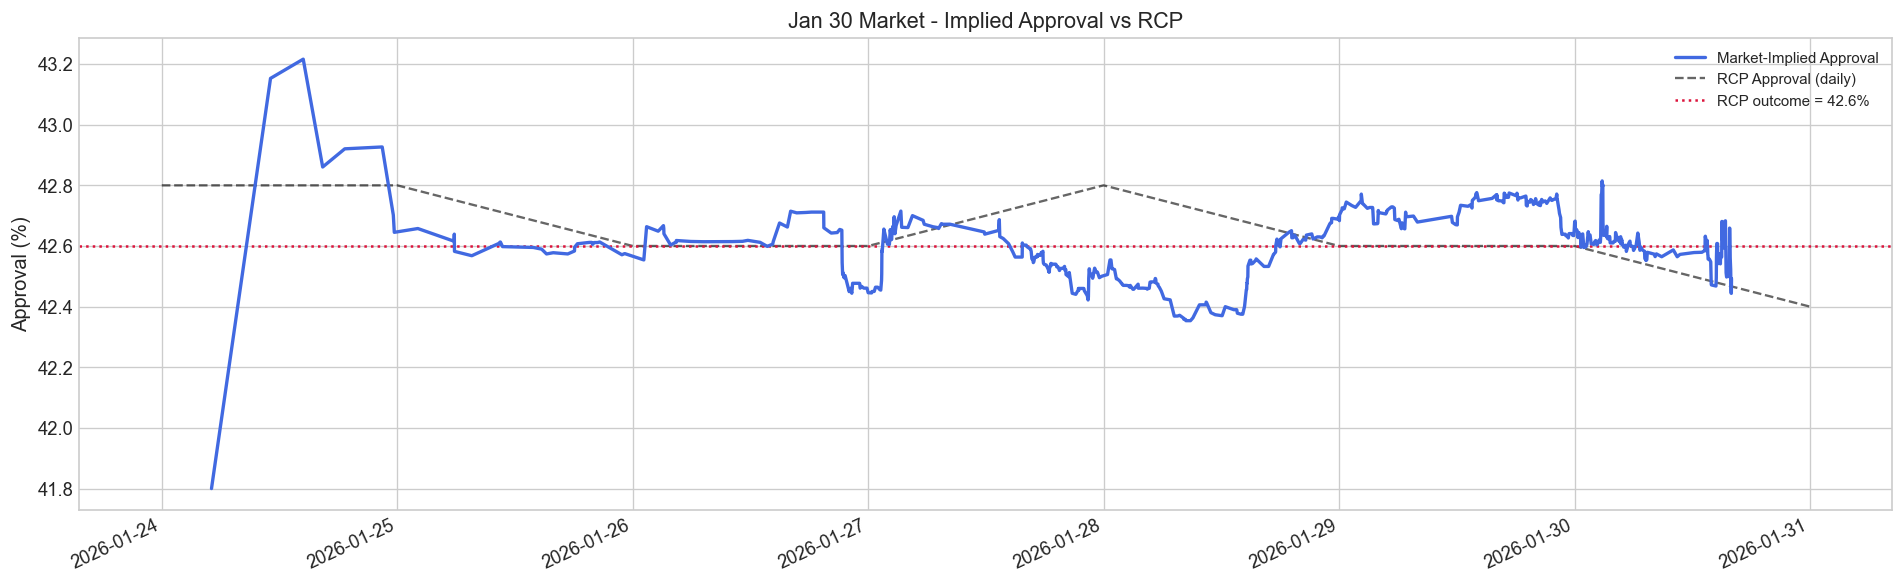

In [6]:
# market-implied approval point-estimate (expected value) together with the realised RCP series and the final RCP outcome.
for key, cfg in MARKETS.items():
    p = cfg['processed']
    ts = p['timestamp']
    fig, ax2 = plt.subplots(figsize=(16, 5))

    #implied approval
    ax2.plot(ts, p['implied_approval'], color='royalblue', lw=2,
             label='Market-Implied Approval', zorder=3)

    t_lo, t_hi = ts.min(), ts.max()
    rw = rcp[(rcp['date'] >= t_lo - pd.Timedelta(days=1)) &
             (rcp['date'] <= t_hi + pd.Timedelta(days=1))]
    if not rw.empty:
        ax2.plot(rw['date'], rw['approve'], 'k--', lw=1.4,
                 alpha=0.6, label='RCP Approval (daily)')

    if cfg.get('outcome') is not None:
        ax2.axhline(cfg['outcome'], color='crimson', ls=':', lw=1.5,
                    label=f'RCP outcome = {cfg["outcome"]:.1f}%')

    ax2.set_ylabel('Approval (%)')
    ax2.set_title(f'{cfg["label"]} - Implied Approval vs RCP')
    ax2.legend(loc='best', fontsize=9)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    fig.autofmt_xdate(rotation=25)
    plt.tight_layout()
    plt.show()


In [1]:
# score each market's final forecast against the realized bucket
# using standard proper scoring rules for categorical/ordinal predictions.

def score_forecast(probs, realized_idx, n):
    """
    proper scoring rules for a probability distribution over n ordered buckets.

    params:
        probs: array of predicted probabilities (sums to 1)
        realized_idx: index of the bucket that actually happened
        n: number of buckets

    returns dict of scoring metrics.
    """
    obs = np.zeros(n)
    obs[realized_idx] = 1.0

    # --- brier score ---
    brier = np.sum((probs - obs) ** 2)

    # brier skill score vs uniform (naive) baseline
    uniform = np.full(n, 1.0 / n)
    brier_uniform = np.sum((uniform - obs) ** 2)
    brier_skill = 1 - (brier / brier_uniform) if brier_uniform > 0 else 0.0

    # --- log score (ignorance score) ---
    p_correct = probs[realized_idx]
    log_score = -np.log(max(p_correct, 1e-10))
    log_baseline = np.log(n)  # score if you predicted uniform
    log_skill = 1 - (log_score / log_baseline) if log_baseline > 0 else 0.0

    # --- ranked probability score (RPS) ---
    cdf_f = np.cumsum(probs)
    cdf_o = np.cumsum(obs)
    rps = np.sum((cdf_f - cdf_o) ** 2) / (n - 1)

    # rps skill vs uniform
    cdf_u = np.cumsum(uniform)
    rps_uniform = np.sum((cdf_u - cdf_o) ** 2) / (n - 1)
    rps_skill = 1 - (rps / rps_uniform) if rps_uniform > 0 else 0.0

    # --- sharpness (concentration of forecast) ---
    entropy = -np.sum(probs * np.log(np.clip(probs, 1e-10, 1)))
    max_entropy = np.log(n)
    sharpness = 1 - (entropy / max_entropy) if max_entropy > 0 else 0.0

    # --- surprise (how many buckets away was the peak from reality) ---
    peak_idx = np.argmax(probs)
    bucket_miss = abs(peak_idx - realized_idx)

    return {
        'P(correct)':   round(p_correct, 4),
        'Brier':        round(brier, 4),
        'Brier_skill':  round(brier_skill, 4),
        'Log_score':    round(log_score, 4),
        'Log_skill':    round(log_skill, 4),
        'RPS':          round(rps, 4),
        'RPS_skill':    round(rps_skill, 4),
        'Sharpness':    round(sharpness, 4),
        'Bucket_miss':  bucket_miss,
    }


rows = []
for key, cfg in MARKETS.items():
    if cfg.get('outcome') is None or cfg.get('realized_bucket_idx') is None:
        continue

    p     = cfg['processed']
    pcols = [f'prob_{b}' for b in cfg['bucket_cols']]

    # terminal distribution = mean of last hour
    last_ts = p['timestamp'].max()
    win     = p[p['timestamp'] >= last_ts - pd.Timedelta(hours=1)]
    fp      = win[pcols].mean().values
    fp      = fp / fp.sum()

    n_buckets = len(cfg['bucket_cols'])
    scores    = score_forecast(fp, cfg['realized_bucket_idx'], n_buckets)

    rows.append({
        'Market':          key,
        'Target':          cfg['target_date'],
        'Outcome':         f'{cfg["outcome"]:.1f}%',
        'Realized bucket': cfg['realized_bucket'],
        'Implied (final)': f'{p["implied_approval"].iloc[-1]:.2f}%',
        **scores,
    })

summary = pd.DataFrame(rows)

# display
print("Forecast Scoring Summary\n")
for _, r in summary.iterrows():
    print(f"{'─'*60}")
    print(f"  {r['Market']}  (target: {r['Target']})")
    print(f"  outcome: {r['Outcome']} → {r['Realized bucket']}")
    print(f"  final implied: {r['Implied (final)']}")
    print(f"\n  accuracy:")
    print(f"    P(correct bucket):    {r['P(correct)']:.2%}")
    print(f"    peak bucket miss:     {r['Bucket_miss']} bucket(s) away")
    print(f"\n  proper scoring rules (lower = better):")
    print(f"    Brier score:          {r['Brier']:.4f}  (skill vs uniform: {r['Brier_skill']:+.2%})")
    print(f"    Log score:            {r['Log_score']:.4f}  (skill vs uniform: {r['Log_skill']:+.2%})")
    print(f"    RPS (ordinal):        {r['RPS']:.4f}  (skill vs uniform: {r['RPS_skill']:+.2%})")
    print(f"    Sharpness:            {r['Sharpness']:.2%}")

print(f"\n{'─'*60}")
print(f"\n  cross-market averages:")
print(f"    mean P(correct):  {summary['P(correct)'].mean():.2%}")
print(f"    mean Brier:       {summary['Brier'].mean():.4f}")
print(f"    mean RPS:         {summary['RPS'].mean():.4f}")
print(f"    mean Brier skill: {summary['Brier_skill'].mean():+.2%}")
print(f"    mean RPS skill:   {summary['RPS_skill'].mean():+.2%}")

summary

NameError: name 'MARKETS' is not defined

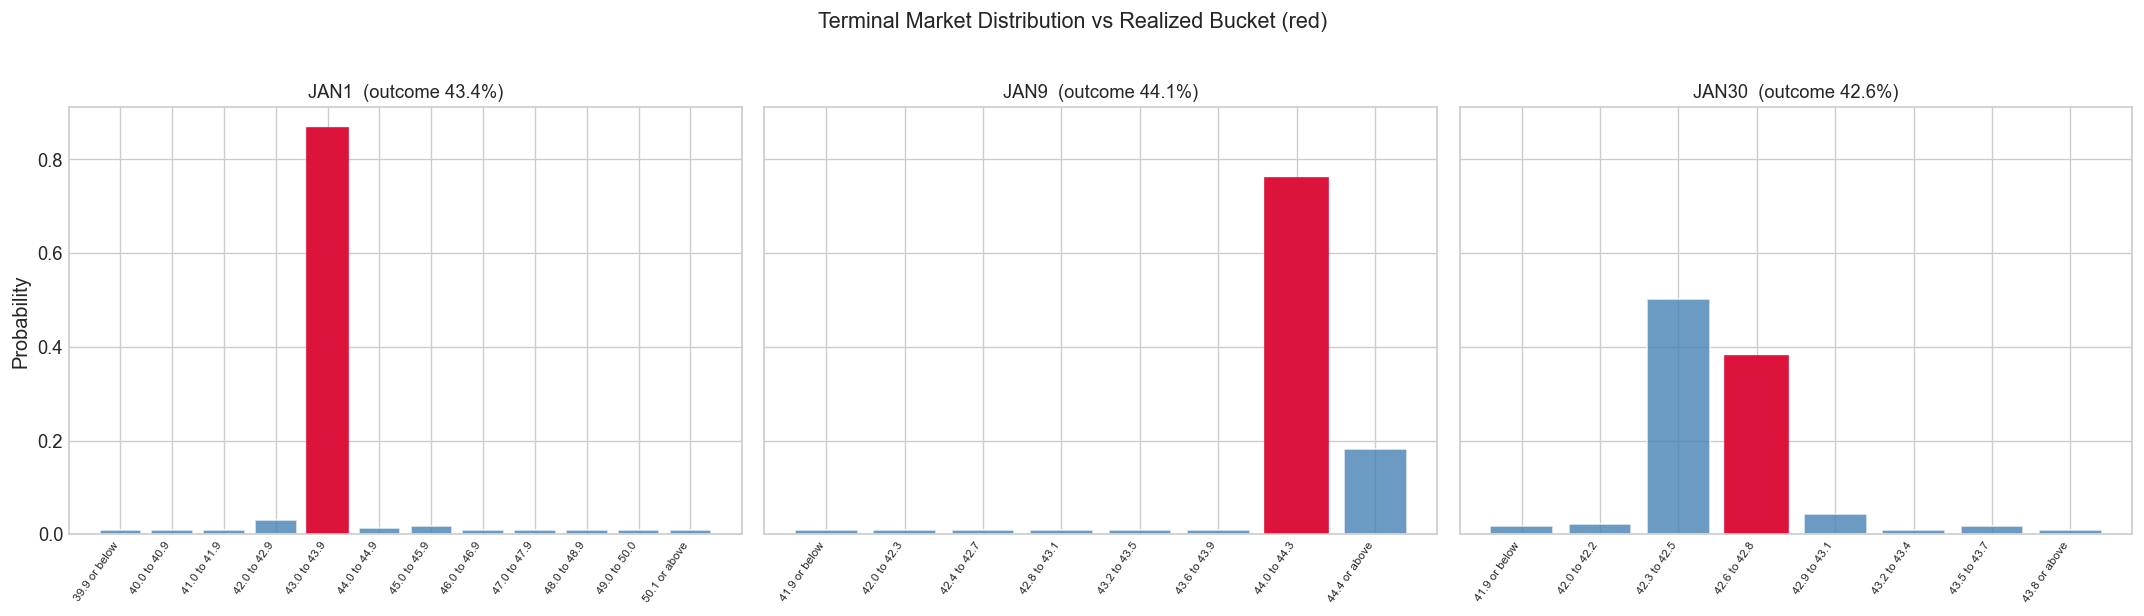

In [8]:
#plot final probability assigned to each bucket, with realised marked
fig, axes = plt.subplots(1, len(MARKETS), figsize=(6 * len(MARKETS), 5),
                         sharey=True)
if len(MARKETS) == 1:
    axes = [axes]

for ax, (key, cfg) in zip(axes, MARKETS.items()):
    if cfg.get('outcome') is None:
        continue
    p     = cfg['processed']
    pcols = [f'prob_{b}' for b in cfg['bucket_cols']]
    last_ts = p['timestamp'].max()
    win  = p[p['timestamp'] >= last_ts - pd.Timedelta(hours=1)]
    fp   = win[pcols].mean().values
    fp   = fp / fp.sum()

    xs   = np.arange(len(cfg['bucket_cols']))
    bars = ax.bar(xs, fp, color='steelblue', alpha=0.8, edgecolor='white')
    if cfg.get('realized_bucket_idx') is not None:
        bars[cfg['realized_bucket_idx']].set_color('crimson')
        bars[cfg['realized_bucket_idx']].set_alpha(1.0)
    ax.set_xticks(xs)
    ax.set_xticklabels(cfg['bucket_cols'], rotation=55, ha='right',
                       fontsize=7)
    ax.set_title(f'{key}  (outcome {cfg["outcome"]:.1f}%)', fontsize=11)
    ax.set_ylabel('Probability' if ax == axes[0] else '')

fig.suptitle('Terminal Market Distribution vs Realized Bucket (red)',
             fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

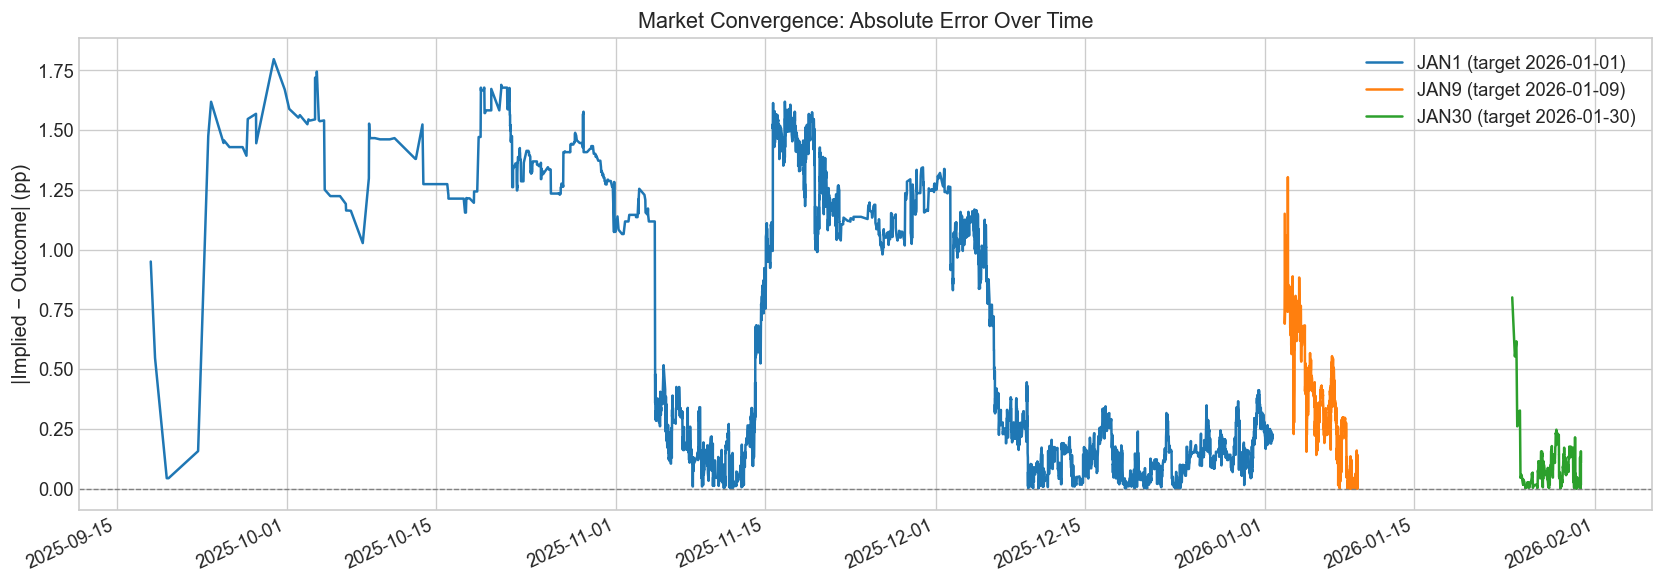

In [9]:
#plot the absolute error over time for each market.
fig, ax = plt.subplots(figsize=(14, 5))
for key, cfg in MARKETS.items():
    if cfg.get('outcome') is None:
        continue
    p = cfg['processed']
    err = (p['implied_approval'] - cfg['outcome']).abs()
    ax.plot(p['timestamp'], err, lw=1.5, label=f'{key} (target {cfg["target_date"]})')
ax.axhline(0, color='grey', ls='--', lw=0.8)
ax.set_ylabel('|Implied − Outcome| (pp)')
ax.set_title('Market Convergence: Absolute Error Over Time')
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate(rotation=25)
plt.tight_layout()
plt.show()